In [1]:
using MLDatasets: BostonHousing
using DataFrames
using StatsBase
using IJulia

In [2]:
dataset = BostonHousing()
# Get information about dataset
dataset.metadata
propertynames(dataset)

(:metadata, :features, :targets, :dataframe)

In [3]:
features = BostonHousing().features
target = BostonHousing().targets

# Split the data set
x_train = features[1:405, :]
x_validation = features[406:456, :]
x_test = features[457:506, :]

y_train = target[1:405, :]
y_validation = target[406:456, :]
y_test = target[457:506, :]

Row,MEDV
,Float64
1,12.7
2,13.5
3,14.9
4,20.0
5,16.4
6,17.7
7,19.5
8,20.2
9,21.4


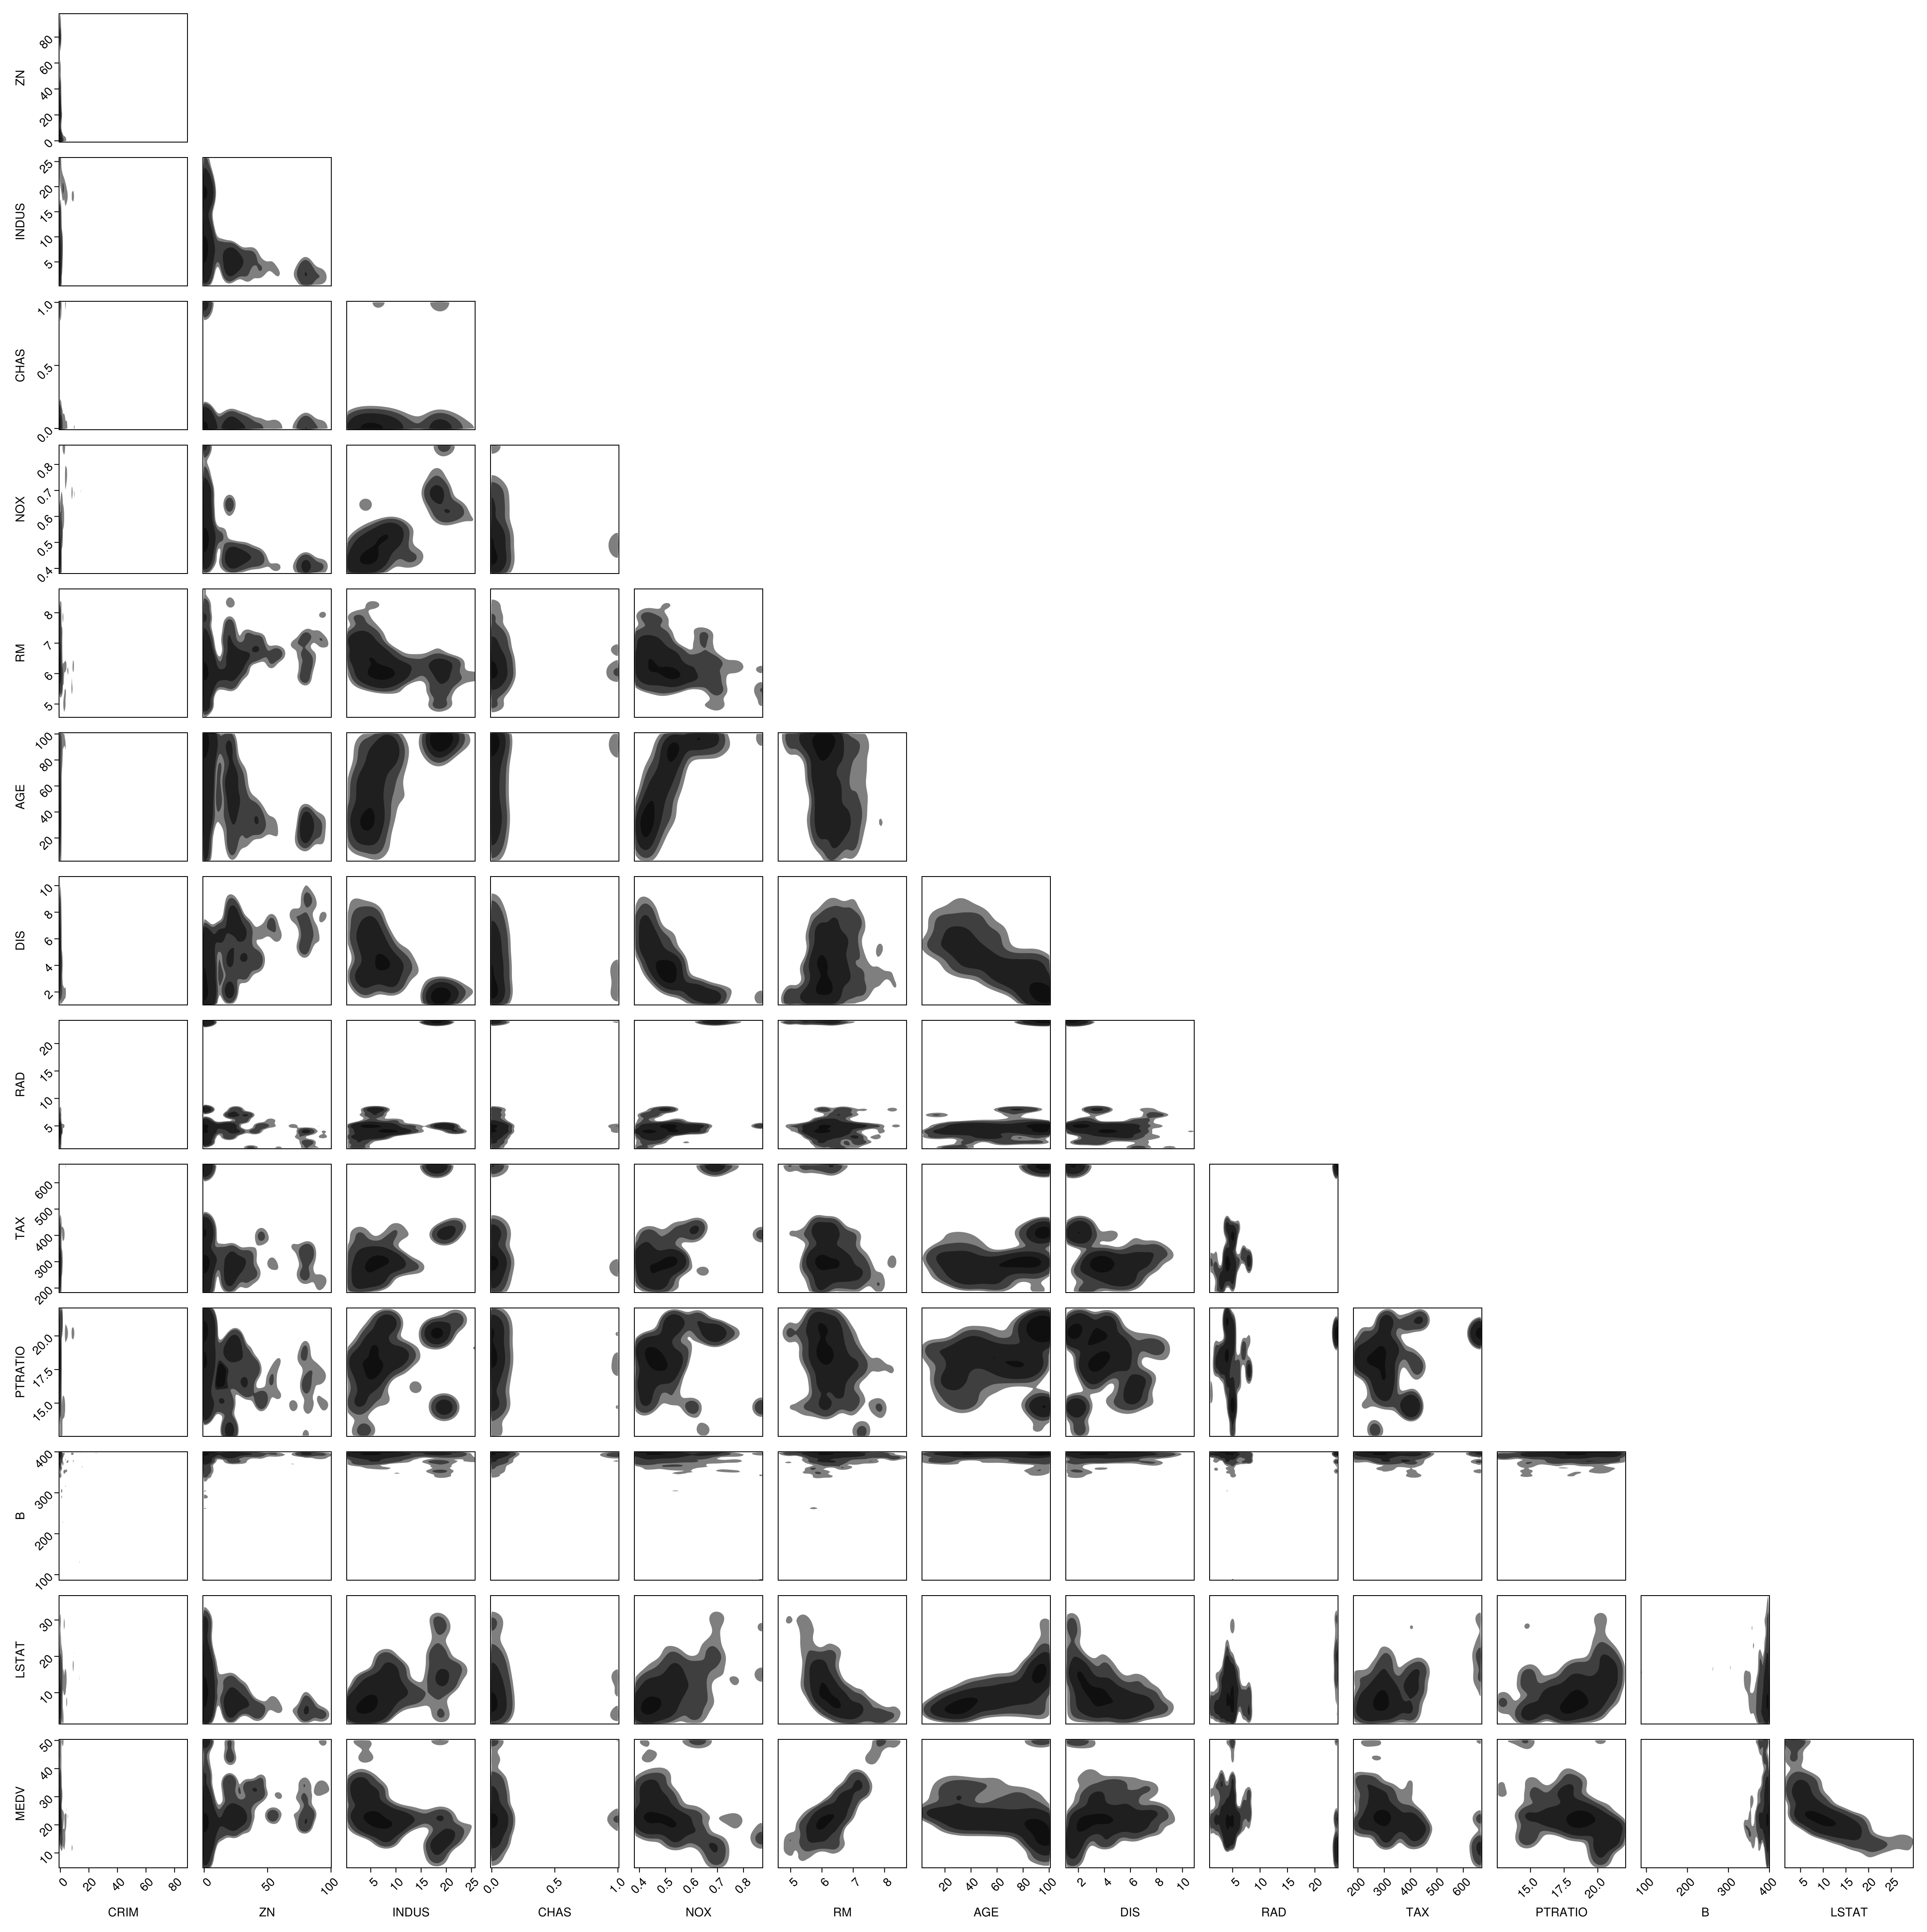

In [4]:
using CairoMakie, PairPlots
data_vis = DataFrame(x_train)
data_vis[!, :MEDV] = y_train.MEDV

plt = pairplot(data_vis => (PairPlots.Contourf(),))

In [5]:
using StatsBase
data_vis_arr = [data_vis[:, i] for i in 1:ncol(data_vis)]
features = propertynames(data_vis)[begin:end-1]
correlations = cor.(Ref(data_vis.MEDV), data_vis_arr)[begin:end-1]
df = DataFrame(feature = features, corr = correlations)
sort(df, [:corr], by = abs, rev = true)

Row,feature,corr
,Symbol,Float64
1,RM,0.748162
2,LSTAT,-0.71106
3,PTRATIO,-0.445596
4,INDUS,-0.390934
5,TAX,-0.344826
6,NOX,-0.323931
7,ZN,0.314426
8,CRIM,-0.308585
9,AGE,-0.294217


In [6]:
# Create a NN model with 3 inputs and 1 output
using Flux
# model 1 
model1 = Dense(2 => 1)
loss1(x, y) = mean((abs2.(model1(x) .- y)));
input = (Matrix(x_train[:, ["RM", "LSTAT"]])')
truth = (Matrix(y_train)')

outpath = abspath((@__DIR__)*"/../train_model1/")
rm(outpath, recursive=true)
mkpath(outpath)

loss1(input, truth)
trueplt = pairplot(data_vis[:, ["RM", "LSTAT", "MEDV"]] => (PairPlots.Contourf(),))
save(joinpath(outpath,"truth_model1.png"), trueplt)
untrained = x_train[:, ["RM", "LSTAT"]]
untrained[!, :MEDV] = vec(model1(input))
plt = pairplot(untrained => (PairPlots.Contourf(),))
save(joinpath(outpath,"untrained_model1.png"), plt)

data = [(input, truth)]
parameters = Flux.params(model1)
opt = Flux.Descent(1e-3)#Flux.setup(Flux.Adam(0.01), model)

parameters = Flux.params(model1)

┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(2 => 1)       # 3 parameters
│   summary(x) = "2×405 adjoint(::Matrix{Float64}) with eltype Float64"
└ @ Flux ~/.julia/packages/Flux/Wz6D4/src/layers/stateless.jl:60


Params([Float32[-0.28177714 -0.018732589], Float32[0.0]])

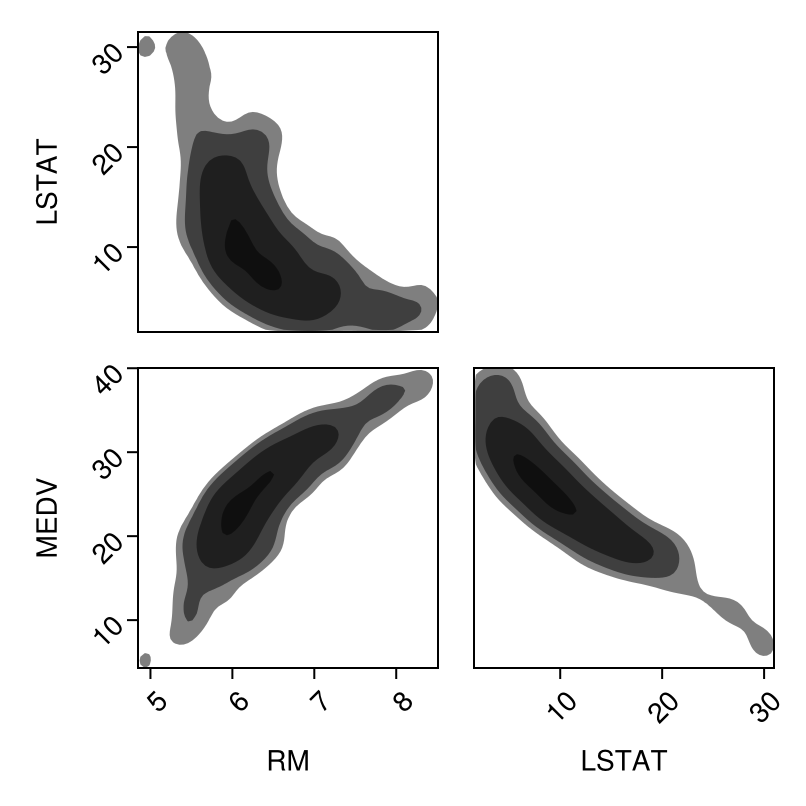

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


In [7]:
using Printf, ProgressMeter
count = 0
losses = []
trained = x_train[:, ["RM", "LSTAT"]]

function callback()
	global count
	trained[!, :MEDV] = vec(model1(input))
	plt = pairplot(trained => (PairPlots.Contourf(),))
	IJulia.clear_output(true)
	display(plt)
	save(joinpath(outpath, "$(lpad(count,3,"0")).png"), plt)
	count += 1
end

throttledcb = Flux.throttle(callback, 0.001)
@showprogress for epoch in 1:200
	push!(losses, loss1(input, truth))
	Flux.train!(loss1, parameters, data, opt, cb = throttledcb)
end

ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.1.0.2.5)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/6.1.1_4 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopen

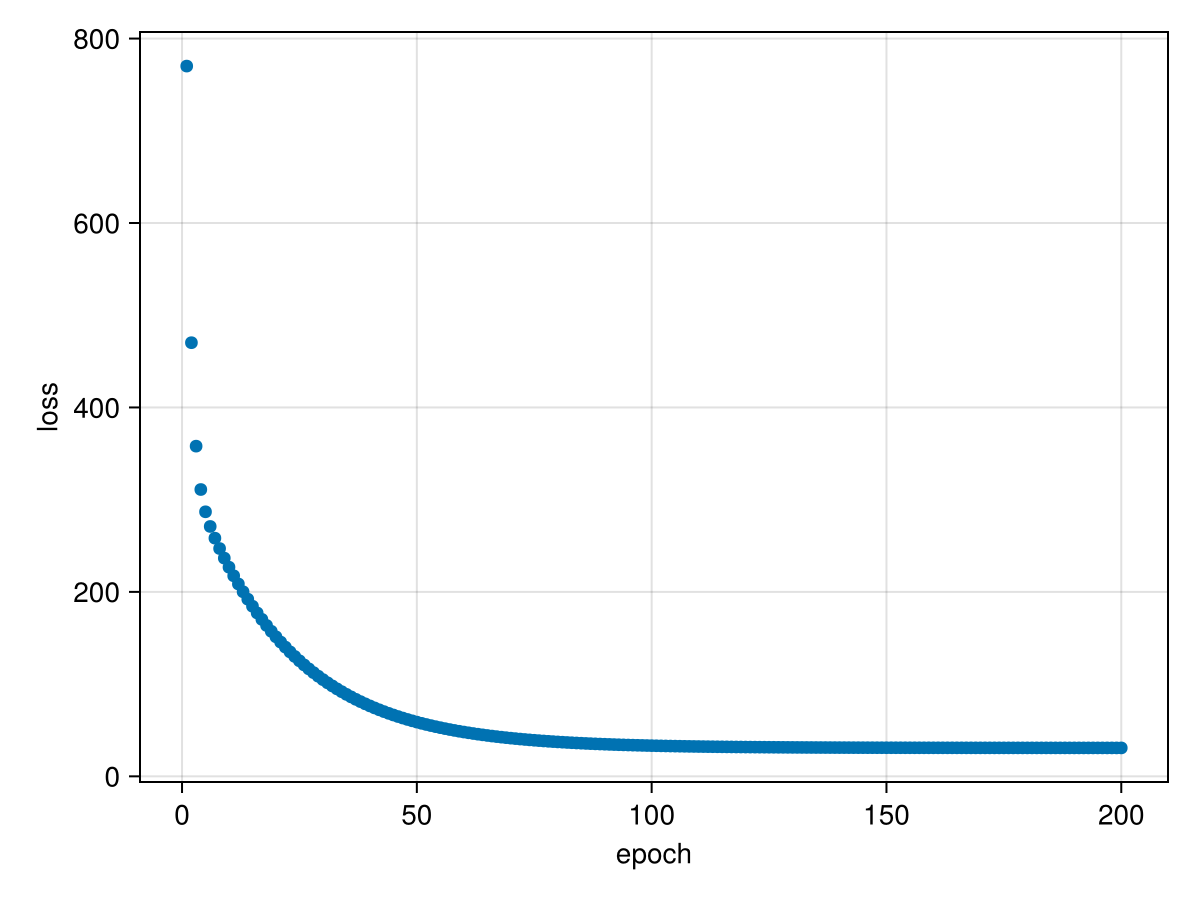

CairoMakie.Screen{IMAGE}


In [8]:
outpath = abspath((@__DIR__)*"/../train_model1/")
rm("$(outpath)train.gif",force=true)
pngpath = joinpath(outpath, "%03d.png")
gifpath = joinpath(outpath, "train.gif")
ffmpeg_script = `ffmpeg -f image2 -framerate 8 -i $(pngpath) $(gifpath)`
run(ffmpeg_script)

plt, ax = scatter(Point2f.(zip(1:length(losses), losses)), ylabel = "epoch")
ax.ylabel = "loss"
ax.xlabel = "epoch"
display(plt)

trained[!, :MEDV] = vec(model1(input))
pairplot(trained => (PairPlots.Contourf(),))
save(joinpath(outpath, "trained_model1.png"), plt)

In [9]:
# model 2
using StatsFuns
outpath = abspath((@__DIR__)*"/../train_model2/")
rm(outpath, recursive=true)
mkpath(outpath)

model2 = Chain(
	Dense(3 => 13, logistic),
	Dense(13 => 1),
)
loss2(x, y) = mean((abs2.(model2(x) .- y)));
input = (Matrix(x_train[:, ["RM", "LSTAT", "PTRATIO"]])')
truth = (Matrix(y_train)')

loss2(input, truth)
trueplt = pairplot(data_vis[:, ["RM", "LSTAT", "PTRATIO", "MEDV"]] => (PairPlots.Contourf(),))
save(joinpath(outpath,"truth_model2.png"), trueplt)
untrained = x_train[:, ["RM", "LSTAT", "PTRATIO"]]
untrained[!, :MEDV] = vec(model2(input))
plt = pairplot(untrained => (PairPlots.Contourf(),))
save(joinpath(outpath,"untrained_model2.png"), plt)

data = [(input, truth)]
parameters = Flux.params(model1)
opt = Flux.Descent(1e-3)

parameters = Flux.params(model2)

Params([Float32[0.25908363 -0.16799134 0.04453767; 0.5098712 -0.29660478 0.025328029; … ; -0.3050358 -0.56812453 0.49146885; 0.21826467 0.52663994 -0.53529054], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.6260508 0.09625053 … 0.16937351 -0.40307876], Float32[0.0]])

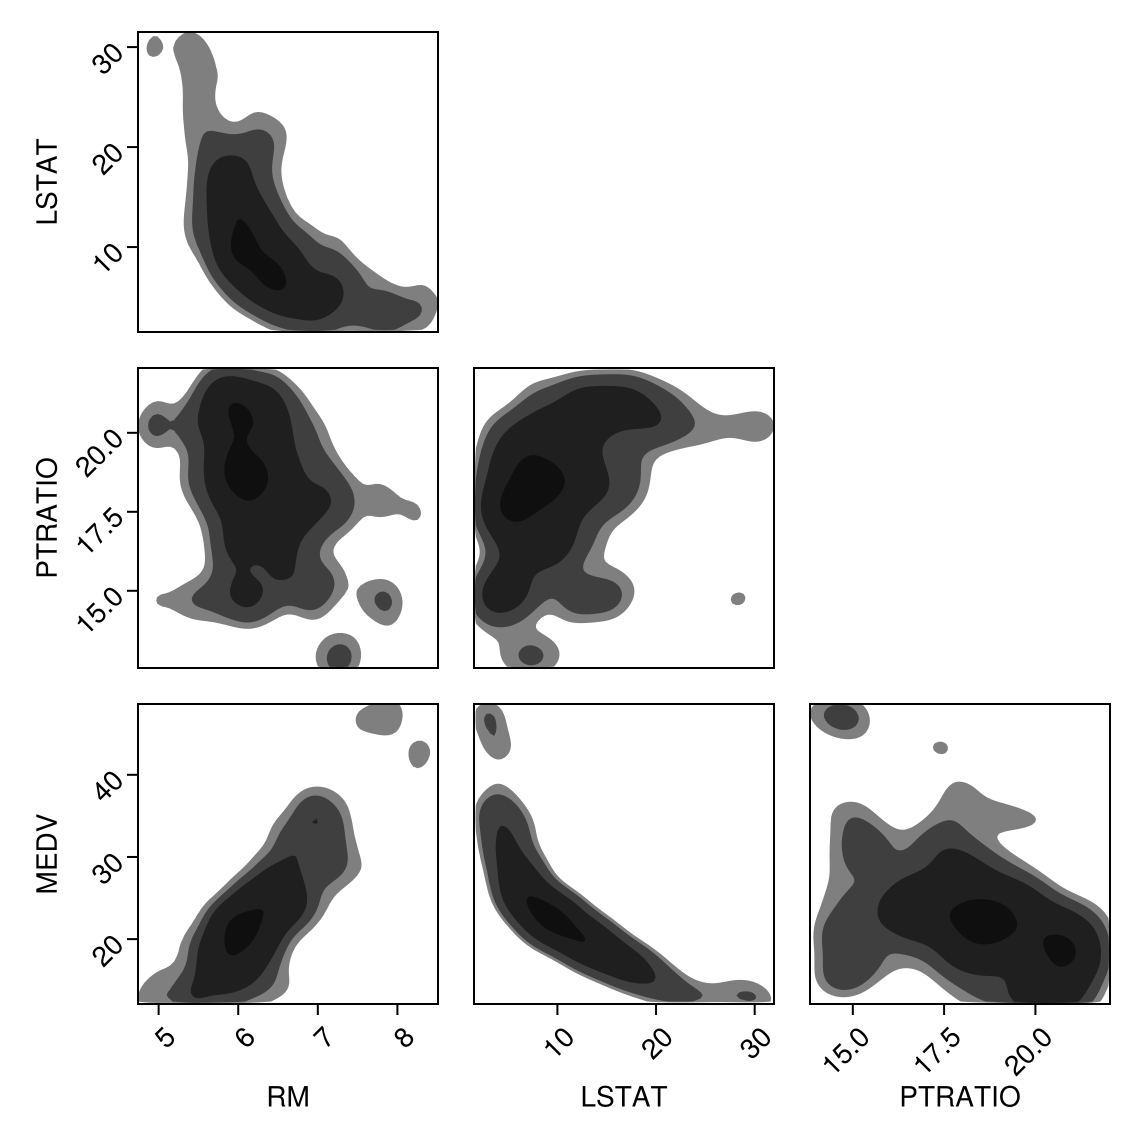

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


In [10]:
count = 0
losses = []
trained = x_train[:, ["RM", "LSTAT", "PTRATIO"]]
function callback()
	global count
	trained[!, :MEDV] = vec(model2(input))
	plt = pairplot(trained => (PairPlots.Contourf(),))
	IJulia.clear_output(true)
	display(plt)
	save(joinpath(outpath, "$(lpad(count,3,"0")).png"), plt)
	count += 1
end
throttledcb = Flux.throttle(callback, 0.2)
@showprogress for epoch in 1:10_000
	push!(losses, loss2(input, truth))
	Flux.train!(loss2, parameters, data, opt, cb = throttledcb)
end

ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.1.0.2.5)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/6.1.1_4 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopen

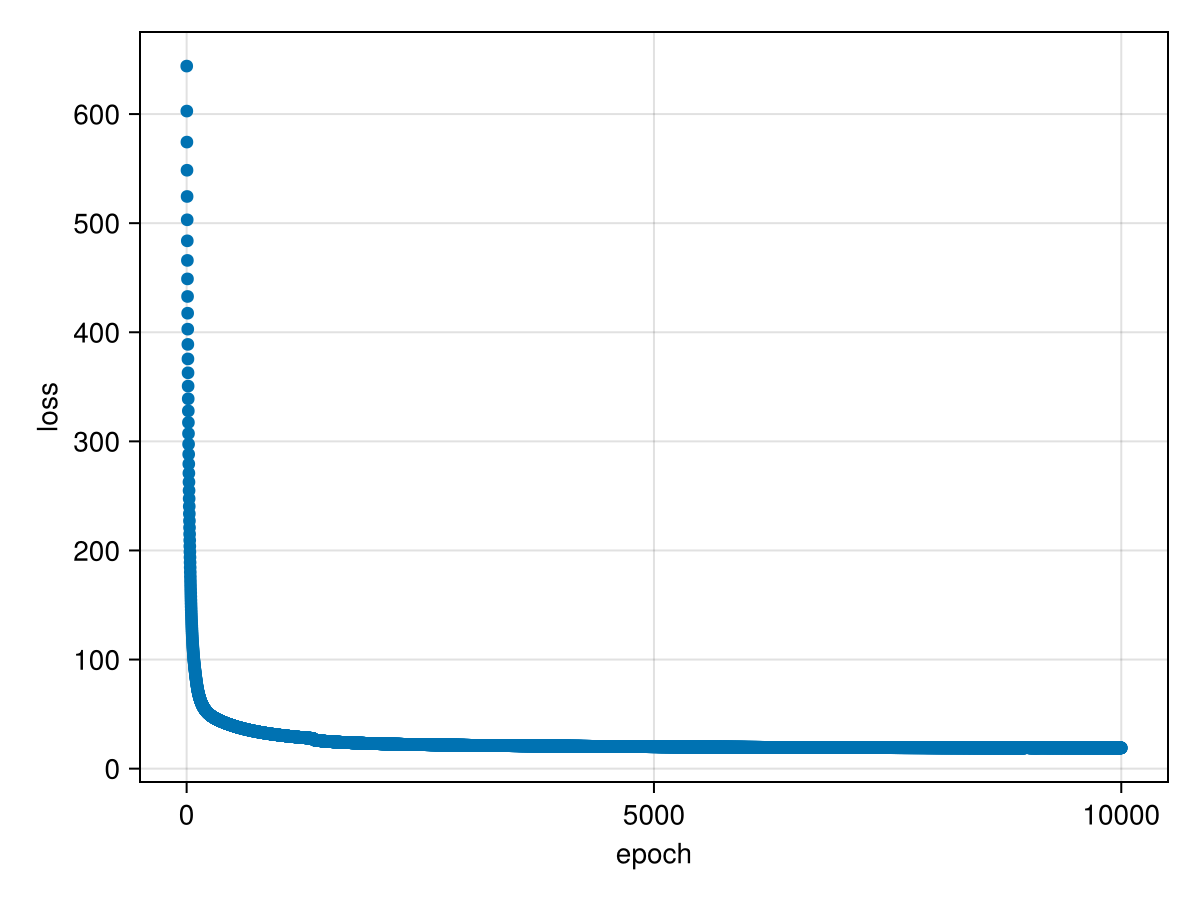

CairoMakie.Screen{IMAGE}


In [11]:
rm(joinpath(outpath, "train.gif"),force=true)
pngpath = joinpath(outpath, "%03d.png")
gifpath = joinpath(outpath, "train.gif")
ffmpeg_script = `ffmpeg -f image2 -framerate 8  -i $(pngpath) $(gifpath)`
run(ffmpeg_script)

plt, ax = scatter(Point2f.(zip(1:length(losses), losses)))
ax.ylabel = "loss"
ax.xlabel = "epoch"
display(plt)

trained = x_train[:, ["RM", "LSTAT", "PTRATIO"]]
trained[!, :MEDV] = vec(model2(input))
pairplot(trained => (PairPlots.Contourf(),))
save("trained_model2.png", plt)


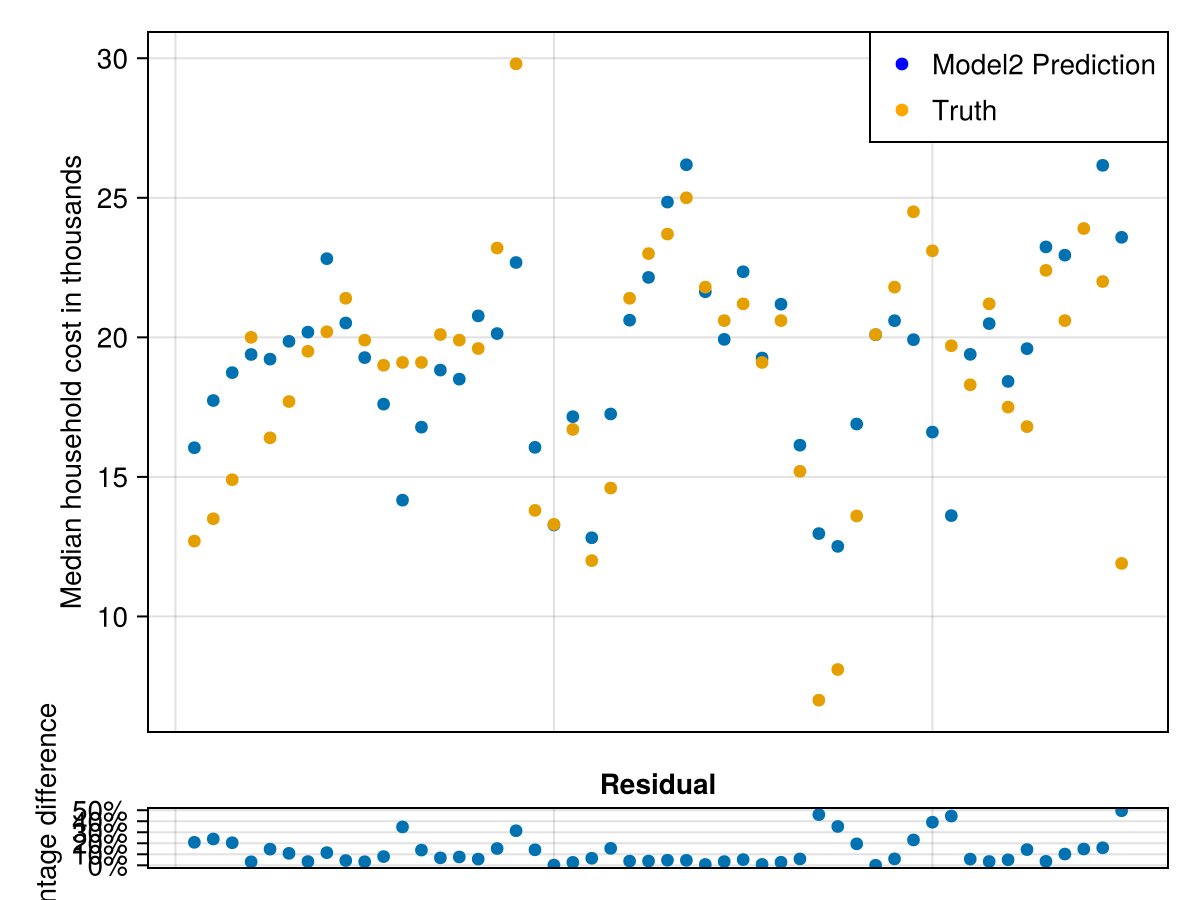

In [12]:
input1 = (Matrix(x_train[:, ["RM", "LSTAT"]])')
loss1(input1, truth)
input2 = (Matrix(x_train[:, ["RM", "LSTAT", "PTRATIO"]])')
loss2(input2, truth)

input1_validation = Matrix(x_validation[:, ["RM", "LSTAT"]])'
input2_validation = Matrix(x_validation[:, ["RM", "LSTAT", "PTRATIO"]])'
truth_validation = Matrix(y_validation)'
loss1(input1_validation, truth_validation)
loss2(input2_validation, truth_validation)


input1_test = Matrix(x_test[:, ["RM", "LSTAT"]])'
input2_test = Matrix(x_test[:, ["RM", "LSTAT", "PTRATIO"]])'
truth_test = Matrix(y_test)'
loss1(input1_test, truth_test)
loss2(input2_test, truth_test)

fig = Figure();
ax0 = Axis(fig[1, 1], height = 350, xticklabelsvisible = false, xticksvisible = false, ylabel = "Median household cost in thousands")
#ax1 = Axis(fig[2,1], title="Residual", xticklabelsvisible=false, xticksvisible=false, ylabel="percentage difference", yticks=(1000:500:3000, ["1000%", "1500%", "2000%", "2500%", "3000%"]))#["0%", "20%", "40%", "60%", "80%", "100%"]))
ax1 = Axis(fig[2, 1], title = "Residual", xticklabelsvisible = false, xticksvisible = false, ylabel = "percentage difference", yticks = (0:10:50, ["0%", "10%", "20%", "30%", "40%", "50%"]))

prediction_vals = vec(model2(input2_test))
truth_vals = vec(truth_test)
model_predictions = CairoMakie.scatter!(ax0, prediction_vals)
scatter!(ax0, truth_vals)

errors = 100.0 .* abs.(prediction_vals .- truth_vals) ./ prediction_vals
scatter!(ax1, errors, title = "residuals")
markers = [
	MarkerElement(marker = :circle, color = :blue),
	MarkerElement(marker = :circle, color = :orange),
]
legend = Legend(
	fig[1, 1],
	markers,
	["Model2 Prediction", "Truth"],
	tellheight = false,
	tellwidth = false,
	halign = :right, valign = :top, orientation = :vertical,
)

display(fig)

RM = 6.0
LSTAT = 20.0
PTRATIO = 17.5
model2([RM, LSTAT, PTRATIO])


#Save model
using BSON: @save
@save (@__DIR__) * "/mymodel.bson" model2